In [1]:
import arviz as az
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm3
import pymc4 as pm4
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability.python.mcmc.transformed_kernel import (
    make_transformed_log_prob,
)

In [2]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
pm3.set_tt_rng(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

az.style.use('arviz-darkgrid')
dtype = tf.float32
tfb = tfp.bijectors
tfd = tfp.distributions

In [3]:
# Helper functions

def get_bounds(samples):
    x_max, y_max = 0, 0
    for x_draws, y_draws in samples.values():
        x_max = max(x_max, np.abs(x_draws).max())
        y_max = max(y_max, np.abs(y_draws).max())
    top = max(x_max, y_max)
    return (-top, top)

def plot_samples(samples):
    fix, axes = plt.subplots(1, 2, squeeze=False, figsize=(12, 4))
    bounds = get_bounds(samples)
    for (label, (x, y)), ax in zip(samples.items(), axes.ravel()):
        ax.plot(x, y, 'o', alpha=0.5)
        ax.set_title(label)
        ax.axes.set_xlim(bounds)
        ax.axes.set_ylim(bounds)

In [4]:
mu = np.zeros(2, dtype=np.float32)
cov = np.array([[50.05, -49.95], [-49.95, 50.05]], dtype=np.float32)
data = np.random.multivariate_normal(mu, cov, size=10000)

In [5]:
model = tfd.JointDistributionSequential(
    [tfd.MultivariateNormalTriL(loc=mu, scale_tril=tf.linalg.cholesky(cov))]
)

joint_log_prob = lambda *x: model.log_prob(x)

In [6]:
# Transformations to bounded space
unconstraining_bijectors = [tfb.Identity()]

posterior = make_transformed_log_prob(
    joint_log_prob,
    unconstraining_bijectors,
    direction="forward",
    enable_bijector_caching=False,
)

In [7]:
def build_fr_advi():
    parameters = model.sample()
    dists = []
    for i, parameter in enumerate(parameters):
        shape = parameter.shape
        ndim = np.prod(shape.as_list())
        loc = tf.Variable(
            tf.random.normal([ndim], dtype=dtype),
            name=f"meanfield_{i}_loc",
            dtype=dtype,
        )
        
        # Build a lower triangular matrix
        scale_tril = tfb.FillScaleTriL(
            diag_bijector=tfb.Chain([
                tfb.Shift(tf.cast(1e-3, dtype)),
                tfb.Softplus(),
                tfb.Shift(tf.cast(np.log(np.expm1(1.)), dtype))
            ]),
            diag_shift=None
        )
        
        cov_param = tfp.util.TransformedVariable(
            tf.eye(ndim, dtype=dtype), 
            scale_tril,
            name='cov_param')
        
        advi_approx = tfd.MultivariateNormalTriL(loc=loc, scale_tril=cov_param)
        dists.append(advi_approx)
    return tfd.JointDistributionSequential(dists)


mean_field = build_fr_advi()

In [8]:
opt = tf.optimizers.Adam(learning_rate=0.1)

@tf.function(autograph=False)
def run_approximation():
    elbo_loss = tfp.vi.fit_surrogate_posterior(
        posterior,
        surrogate_posterior=mean_field,
        num_steps=10000,
        optimizer=opt
    )
    return elbo_loss


elbo_loss = run_approximation()

Instructions for updating:
The signature for `trace_fn`s passed to `minimize` has changed. Trace functions now take a single `traceable_quantities` argument, which is a `tfp.math.MinimizeTraceableQuantities` namedtuple containing `traceable_quantities.loss`, `traceable_quantities.gradients`, etc. Please update your `trace_fn` definition.


In [9]:
samples = mean_field.sample(10000)[0]

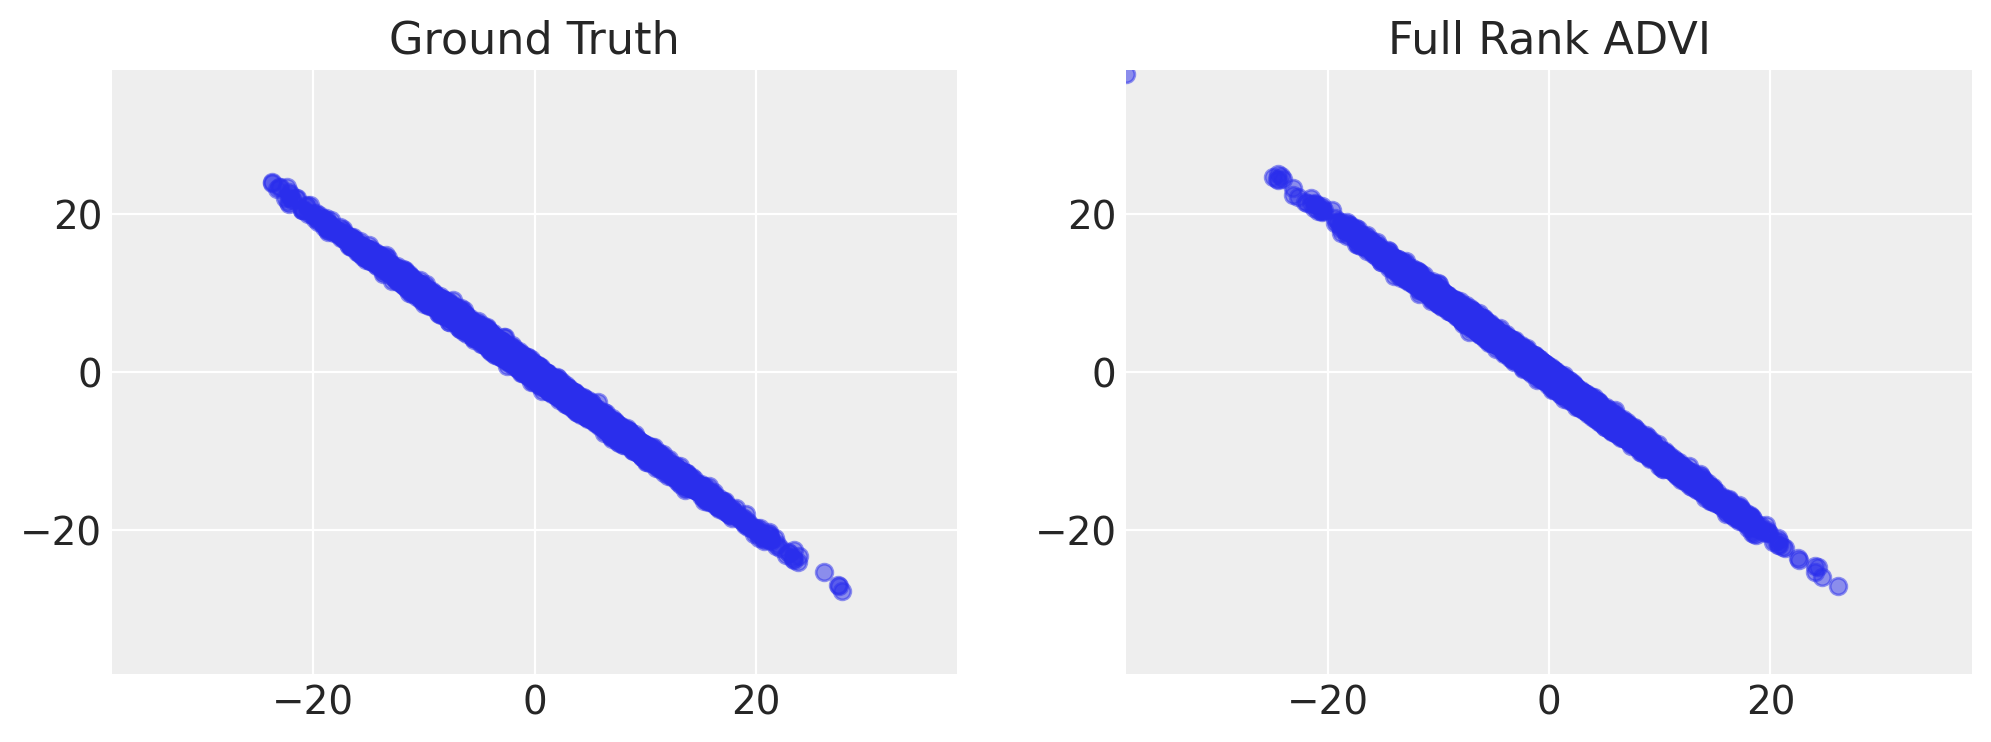

In [10]:
samples_dict = dict()
samples_dict['Ground Truth'] = (data[:, 0], data[:, 1])
samples_dict['Full Rank ADVI'] = (samples[:, 0], samples[:, 1])
plot_samples(samples_dict)